In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle

rectangular_ = 1
elliptic_ = 2

nCore_y = 2
nCore_z = 2
npt = 50000
nturn = 101

In [2]:
emitGeomRMS = 3.3e-6
dE = 2.0e-3

In [3]:
NL_t = 0.4
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

In [4]:
impact.getElem('write_raw_ptcl')


          type: 'write_raw_ptcl'
       file_id: 1000
     format_id: 1
          turn: 1
 sample_period: 1

# read Aperture

In [5]:
beam,lattice = impact.readInputFile('../test.Chad.in')
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg

reading ImpactZ input file (../test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [6]:
def getLostDataThermal(deco,H0,tauMag,tauBeam,npt,nturn,order=3):
    
    # read file
    beam,lattice = impact.readInputFile('test_'+deco+'.in')
    beam.nCore_y=nCore_y
    beam.nCore_z=nCore_z
    beam.n_particles = npt
    ke = beam.kinetic_energy
    mass = beam.mass
    freq = beam.frequency
    
    
    # adjust kick number
    cleanLat = impact.clearLattice(lattice)
    for item in cleanLat:
        if item.type == 'RFkick':
            item.vmax = 0.0
        if 'length' in item:
            item.n_sckick = int(np.ceil(item.length*50))
            item.n_map = 1
            
    for iNL,item in enumerate(cleanLat):
        if item.type == 'nonlinear_insert':
            NLfoward = item
            break
    
    NLfoward.n_sckick = 90
    NLfoward.n_map = 1
    NLfoward.strength_t = tauMag

    
    # add QFF
    cleanLat = impact.addHardEdgeQuad(cleanLat)
    
    
    # ==== run backward (to injection point) =====
    for iNL,item in enumerate(cleanLat):
        if item.type == 'nonlinear_insert':
            NLfoward = item
            break
    
    NLfoward.n_sckick = 90
    NLfoward.n_map = 1
    NLfoward.strength_t = tauMag


    latticeB = impact.getInverseLattice(cleanLat[:iNL])
    
    write0 = impact.getElem('write_raw_ptcl')
    write0.file_id = 111110
    write0.format_id = 2
    latticeB.insert(0,write0)

    write1 = impact.getElem('write_raw_ptcl')
    write1.file_id = 111111
    write1.format_id = 2
    latticeB.append(write1)

    loop = impact.getElem('loop')
    loop.turns = 1
    latticeB.insert(0,loop)
    
    beam.distribution.mode = 'twiss'
    beam.distribution.distribution_type = 'IOTA_Gauss'
    beam.distribution.NL_t  = tauBeam
    beam.distribution.NL_c  = NL_c
    beam.distribution.betx  = NL_L/np.sin(2.0*np.pi*NL_nu)
    beam.distribution.alfx  = np.tan(np.pi*NL_nu)
    beam.distribution.emitx = H0
    beam.distribution.CL    = 6.0
    beam.distribution.betz  = 200
    beam.distribution.alfz  = 0.0
    beam.distribution.emitz = (dE*ke*1.0e-6)**2*beam.distribution.betz
    
    impact.writeInputFile(beam,latticeB)
    impact.run(beam,order=order)
    
    pData0 = impact.readParticleData(111110,ke,mass,freq,2)
    Twiss0 = impact.getTwiss_from_pData(pData0)
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    
    
    # ==== run foward (from injection point) ====
    loop = impact.getElem('loop')
    loop.turns = nturn
    
    writeP = []
    for i in range(10):
        writeP.append(impact.getElem('write_raw_ptcl'))
        print(i+1)
        writeP[-1].file_id = 700 + i
        writeP[-1].format_id = 2
        writeP[-1].turn = i+1
    for i in range(10):
        writeP.append(impact.getElem('write_raw_ptcl'))
        writeP[-1].file_id = 700 + (i+1)*10 +1
        writeP[-1].format_id = 2
        writeP[-1].turn = (i+1)*10 +1
        print((i+1)*10 +1)
    
    NL_sliced0 = impact.getElem('nonlinear_insert_sliced')
    NL_sliced0.length = 0.9
    NL_sliced0.total_length = 1.8
    NL_sliced0.start_position = 0.0
    NL_sliced0.n_sckick = 45
    NL_sliced0.n_map = 1
    NL_sliced0.strength_t = 0.4
    NL_sliced0.transverse_scale_c = 0.01
    NL_sliced0.pipe_radius = 1.0

    NL_sliced1 = copy(NL_sliced0)
    NL_sliced1.start_position = 0.9
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = 111111
    
    
    lattice = [loop] +cleanLat[:iNL] +[NL_sliced0] +writeP +[NL_sliced1] +cleanLat[iNL+1:]     
    impact.writeInputFile(beam, lattice)
    impact.run(beam,order=order)
    
    
    # ==== get Data ====
    pData = []
    for i in range(10):
        pData.append(impact.readParticleData(700 + i,ke,mass,freq,2))
        
    for i in range(10):
        pData.append(impact.readParticleData(700 + (i+1)*10 +1,ke,mass,freq,2))

    #!rm lost_partcl.data fort.* test.in
    
    return pData

# Run and collect data

In [7]:
Deco = ['iota_v8_4_SextOff_NLon',
        'iota_v8_4_SextOn_NLon',
        'iota_v8_4_SextGoodDA_NLon']
# data = {}
data = pickle.load(open('distEvol_iota_v8_4_variousSextSettings.pickle','rb'))

## Thermal Beam

#### iota_v8_4_SextOff_NLon

In [8]:
deco = 'iota_v8_4_SextOff_NLon'
if deco+'_thermal' not in data.keys():
    data[deco+'_thermal']=getLostDataThermal(deco,emitGeomRMS,0.4,0.4,npt,nturn)

In [9]:
deco = 'iota_v8_4_SextOn_NLon'
if deco+'_thermal' not in data.keys():
    data[deco+'_thermal']=getLostDataThermal(deco,emitGeomRMS,0.4,0.4,npt,nturn)

In [10]:
deco = 'iota_v8_4_SextGoodDA_NLon'
if deco+'_thermal' not in data.keys():
    data[deco+'_thermal']=getLostDataThermal(deco,emitGeomRMS,0.4,0.4,npt,nturn)

In [11]:
# pickle.dump(data,open('distEvol_iota_v8_4_variousSextSettings.pickle','wb'))

In [12]:
TURN = []
for i in range(10):
    TURN.append(i)
for i in range(10):
    TURN.append((i+1)*10)

In [13]:
ap0_x,ap0_y = 0.00680513, 0.00935705
ap1_x,ap1_y = 4.00000000e-03, 5.50000000e-03
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

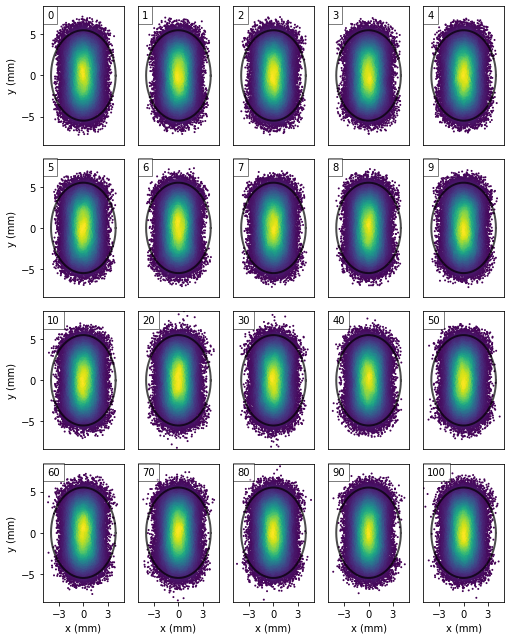

In [14]:
deco = 'iota_v8_4_SextOff_NLon'
plt.figure(figsize=(4*1.8,5*1.8))
i=0
for item in data[deco+'_thermal']:
#     item = data[deco+'_thermal'][i]
    plt.subplot(4,5,i+1)
    impact.plot.density(item[:,0]*1e3,item[:,2]*1e3)
#     plt.plot(ap0_x*c*1e3,ap0_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.text(-4.5,7,str(TURN[i]),bbox=dict(facecolor='white', alpha=0.5))
    if i%5!=0:
        plt.yticks([])
    else:
        plt.ylabel('y (mm)')
    if i<15:
        plt.xticks([])
    else:
        plt.xticks([-3,0,3])
        plt.xlabel('x (mm)')
    plt.xlim(-5,5)
    plt.ylim(-8.4,8.4)
    i=i+1
plt.tight_layout()
plt.savefig('distEvol_'+deco+'.png',dpi=180)

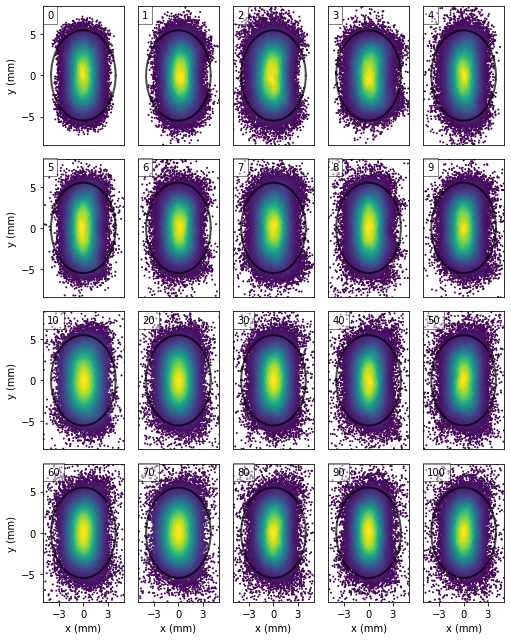

In [15]:
deco = 'iota_v8_4_SextOn_NLon'
plt.figure(figsize=(4*1.8,5*1.8))
i=0
for item in data[deco+'_thermal']:
#     item = data[deco+'_thermal'][i]
    plt.subplot(4,5,i+1)
    impact.plot.density(item[:,0]*1e3,item[:,2]*1e3)
#     plt.plot(ap0_x*c*1e3,ap0_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.text(-4.5,7,str(TURN[i]),bbox=dict(facecolor='white', alpha=0.5))
    if i%5!=0:
        plt.yticks([])
    else:
        plt.ylabel('y (mm)')
    if i<15:
        plt.xticks([])
    else:
        plt.xticks([-3,0,3])
        plt.xlabel('x (mm)')
    plt.xlim(-5,5)
    plt.ylim(-8.4,8.4)
    i=i+1
plt.tight_layout()
plt.savefig('distEvol_'+deco+'.png',dpi=180)

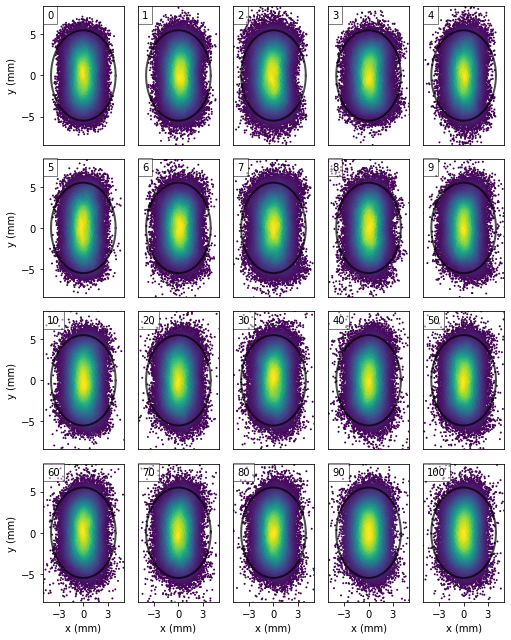

In [16]:
deco = 'iota_v8_4_SextGoodDA_NLon'
plt.figure(figsize=(4*1.8,5*1.8))
i=0
for item in data[deco+'_thermal']:
#     item = data[deco+'_thermal'][i]
    plt.subplot(4,5,i+1)
    impact.plot.density(item[:,0]*1e3,item[:,2]*1e3)
#     plt.plot(ap0_x*c*1e3,ap0_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.text(-4.5,7,str(TURN[i]),bbox=dict(facecolor='white', alpha=0.5))
    if i%5!=0:
        plt.yticks([])
    else:
        plt.ylabel('y (mm)')
    if i<15:
        plt.xticks([])
    else:
        plt.xticks([-3,0,3])
        plt.xlabel('x (mm)')
    plt.xlim(-5,5)
    plt.ylim(-8.4,8.4)
    i=i+1
plt.tight_layout()
plt.savefig('distEvol_'+deco+'.png',dpi=180)